In [1]:
import numpy as np
import pandas as pd

import os

from numpy import array
import torch
import gc
import torch.nn as nn
from tqdm import tqdm_notebook as tqdm
from torch.utils.data import Dataset,DataLoader

### Daily Birth DF

In [2]:
daily_birth_df = pd.read_csv('data/daily-total-female-births.csv')

In [3]:
daily_birth_df.shape

(365, 2)

In [4]:
daily_birth_df['Births'] = np.float32(daily_birth_df['Births'])
daily_birth_df['Births'].dtype

dtype('float32')

#### Train & Valid split

In [5]:
# split data into train and valid

daily_birth_df_values = daily_birth_df['Births'].values
train_set, valid_set = daily_birth_df_values[0:-165], daily_birth_df_values[-165:]
print('Proportion of train_set : {:.2f}%'.format(len(train_set)/len(daily_birth_df)))
print('train_set has {} values'.format(len(train_set)))
print('Proportion of valid_set : {:.2f}%'.format(len(valid_set)/len(daily_birth_df)))
print('valid_set has {} values'.format(len(valid_set)))

Proportion of train_set : 0.55%
train_set has 200 values
Proportion of valid_set : 0.45%
valid_set has 165 values


In [6]:
def split_sequence(sequence, n_steps):
    x, y = list(), list()
    for i in range(len(sequence)):
        
        end_ix = i + n_steps
        
        if end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        # print('seq_x: {}, seq_y: {}'.format(seq_x, seq_y))
        x.append(seq_x)
        y.append(seq_y)
    return array(x), array(y)

#raw_seq = [10,20,30,40,50,60,70,80,90]
n_steps = 3
train_x,train_y = split_sequence(train_set,n_steps)
valid_x,valid_y = split_sequence(valid_set,n_steps)

### Build CNN Forecast Model

In [7]:
class DailyBirthDataset(Dataset):
    def __init__(self,feature,target):
        self.feature = feature
        self.target = target
    
    def __len__(self):
        return len(self.feature)
    
    def __getitem__(self,idx):
        item = self.feature[idx]
        label = self.target[idx]
        
        return item,label

In [8]:
class CNN_ForecastNet(nn.Module):
    def __init__(self):
        super(CNN_ForecastNet,self).__init__()
        self.conv1d = nn.Conv1d(3,64,kernel_size=1)
        self.relu = nn.ReLU(inplace=True)
        self.fc1 = nn.Linear(64,50)
        self.fc2 = nn.Linear(50,1)
        
    def forward(self,x):
        x = self.conv1d(x)
        x = self.relu(x)
        x = x.view(-1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        
        return x

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CNN_ForecastNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.MSELoss()

#### Do I have to think autocorrelation when setting batch_size? 
Maybe Batch_size is important, and It is related with autocorrelation I guess.

In [10]:
train = DailyBirthDataset(train_x.reshape(train_x.shape[0],train_x.shape[1],1),train_y)
valid = DailyBirthDataset(valid_x.reshape(valid_x.shape[0],valid_x.shape[1],1),valid_y)

train_loader = torch.utils.data.DataLoader(train,batch_size=1,shuffle=False)
valid_loader = torch.utils.data.DataLoader(train,batch_size=1,shuffle=False)

In [11]:
train_losses = []
valid_losses = []
def Train():
    
    running_loss = .0
    
    model.train()
    
    for idx, (inputs,labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model(inputs.float())
        loss = criterion(preds,labels)
        loss.backward()
        optimizer.step()
        running_loss += loss
        
    train_loss = running_loss/len(train_loader)
    train_losses.append(train_loss.detach().numpy())
    
    print(f'train_loss {train_loss}')
    
def Valid():
    running_loss = .0
    
    model.eval()
    
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            preds = model(inputs.float())
            loss = criterion(preds,labels)
            running_loss += loss
            
        valid_loss = running_loss/len(valid_loader)
        valid_losses.append(valid_loss.detach().numpy())
        print(f'valid_loss {valid_loss}')

In [12]:
epochs = 200
for epoch in range(epochs):
    print('epochs {}/{}'.format(epoch+1,epochs))
    Train()
    Valid()
    gc.collect()

epochs 1/200
train_loss 1327.133544921875
valid_loss 1247.72216796875
epochs 2/200
train_loss 1171.701171875
valid_loss 1097.4569091796875
epochs 3/200
train_loss 1026.9285888671875
valid_loss 958.6016845703125
epochs 4/200
train_loss 894.1668701171875
valid_loss 832.2120971679688
epochs 5/200
train_loss 774.2423706054688
valid_loss 718.3331909179688
epochs 6/200
train_loss 665.7798461914062
valid_loss 614.9916381835938
epochs 7/200
train_loss 567.1595458984375
valid_loss 521.0087890625
epochs 8/200
train_loss 477.767578125
valid_loss 436.1954040527344
epochs 9/200
train_loss 397.5462951660156
valid_loss 360.6091003417969
epochs 10/200
train_loss 326.8674011230469
valid_loss 294.91741943359375
epochs 11/200
train_loss 266.1341857910156
valid_loss 239.1308135986328
epochs 12/200
train_loss 215.20755004882812
valid_loss 192.98463439941406
epochs 13/200
train_loss 173.69888305664062
valid_loss 155.99769592285156
epochs 14/200
train_loss 141.0039825439453
valid_loss 127.42308807373047
epoc

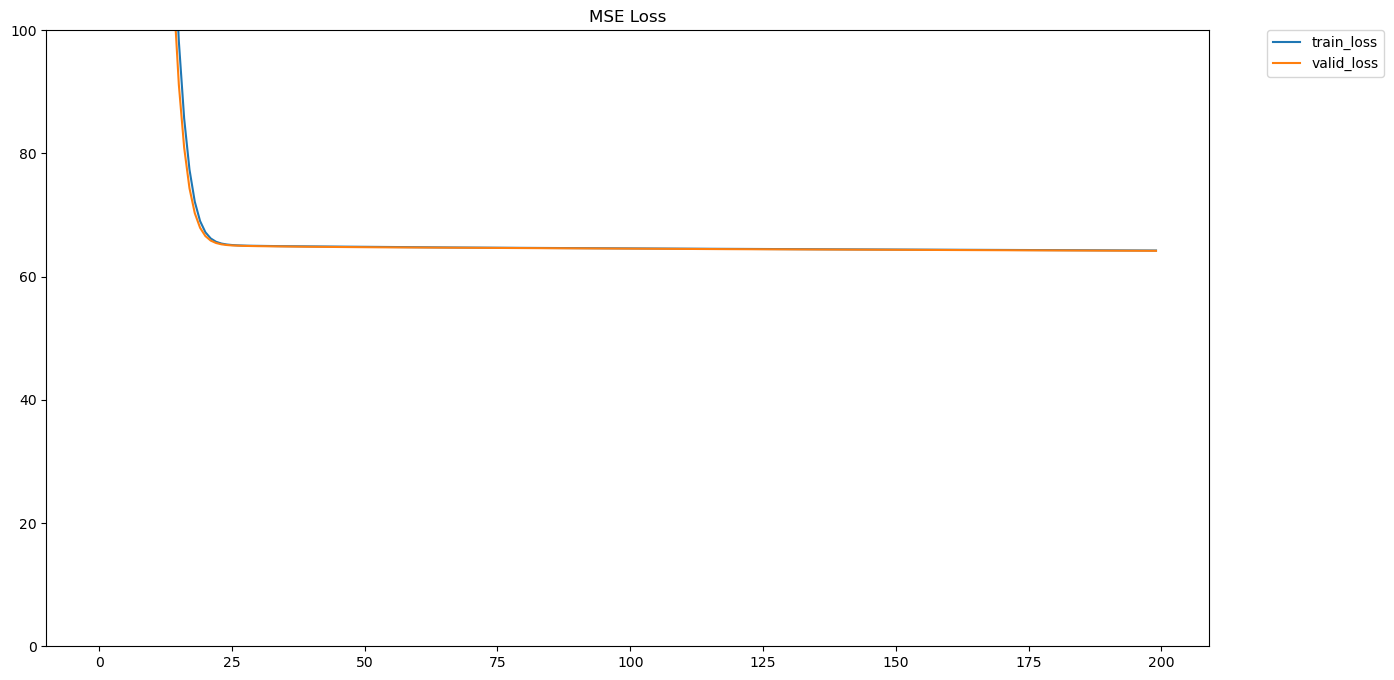

In [13]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize']=[15,8]

plt.plot(train_losses,label='train_loss')
plt.plot(valid_losses,label='valid_loss')
plt.title('MSE Loss')
plt.ylim(0, 100)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

In [14]:
target_x , target_y = split_sequence(valid_set,n_steps)
inputs = target_x.reshape(target_x.shape[0],target_x.shape[1],1)

In [15]:
model.eval()
prediction = []
batch_size = 1
iterations =  int(inputs.shape[0])

for i in range(iterations):
    preds = model(torch.tensor(inputs[batch_size*i:batch_size*(i+1)]).float())
    prediction.append(preds.detach().numpy())

#### Prediction Result

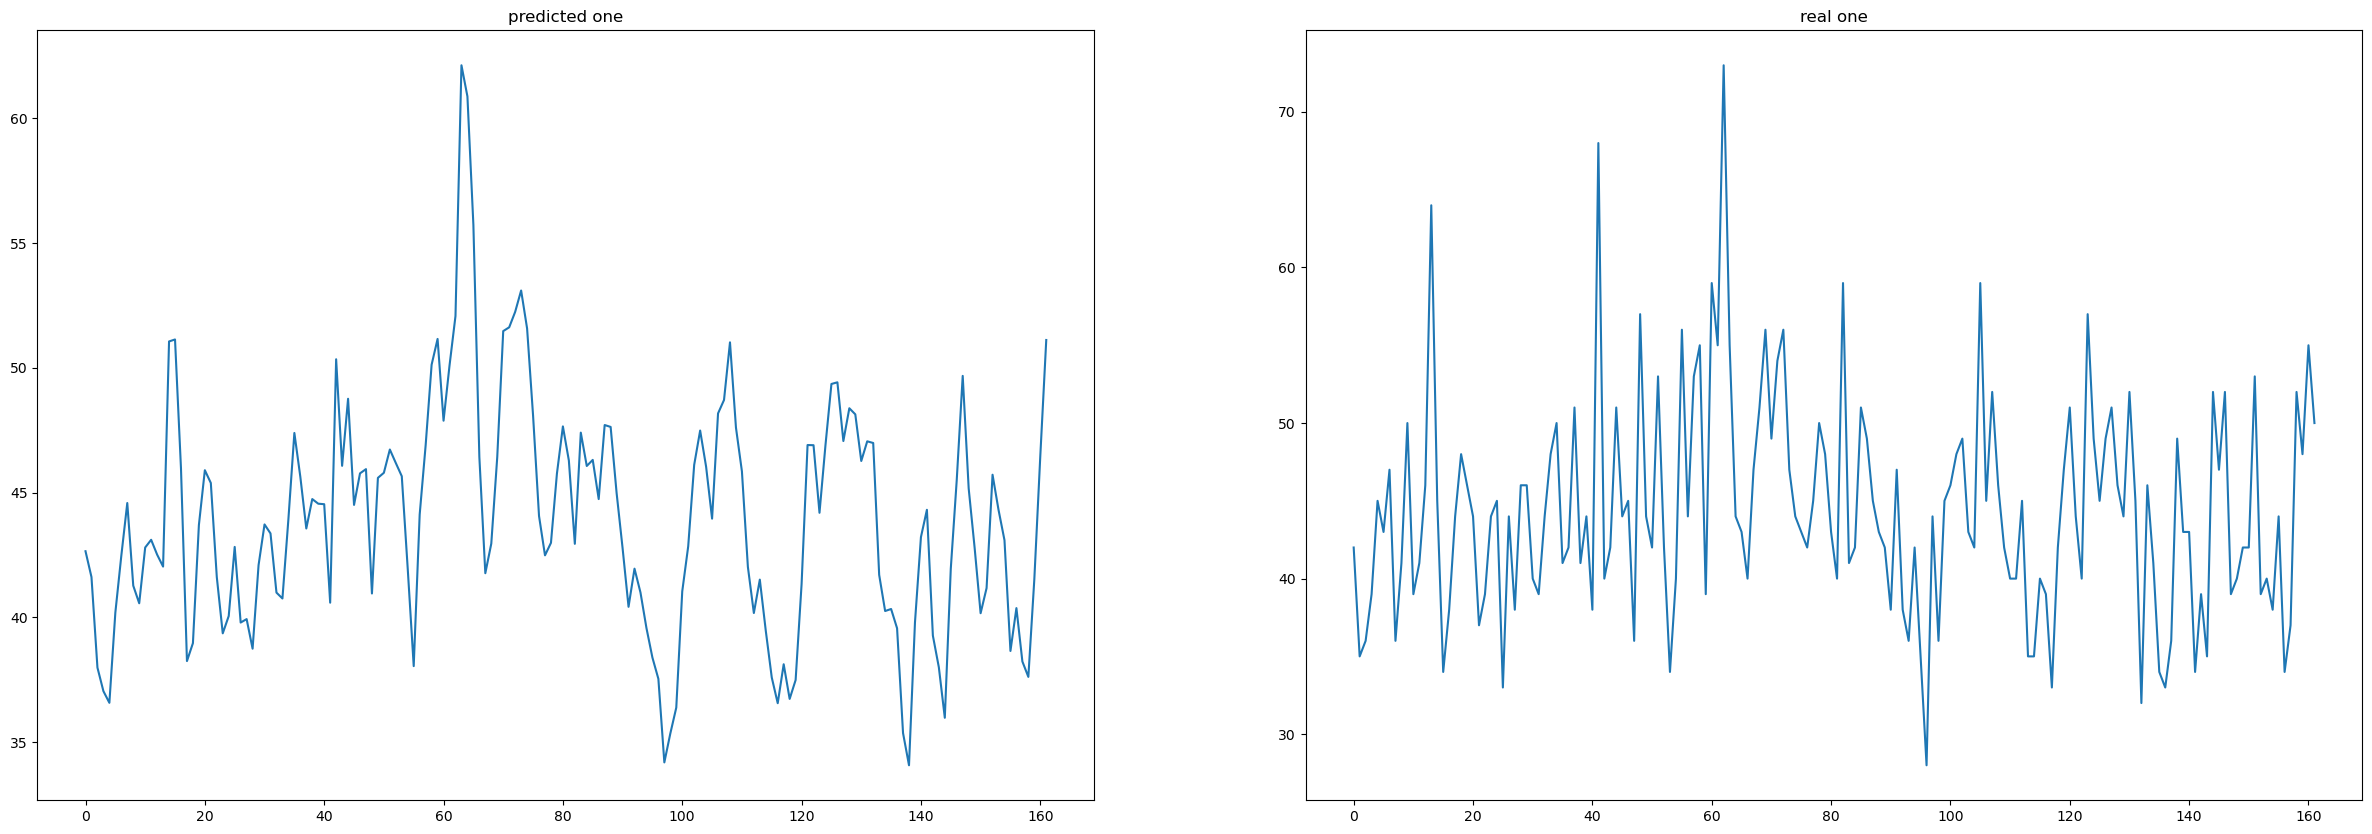

In [16]:
plt.rcParams['figure.figsize']=[30,10]

fig, ax = plt.subplots(1, 2,figsize=(11,4))
fig.set_figheight(10)
fig.set_figwidth(30)
ax[0].set_title('predicted one')
ax[0].plot(prediction)
ax[1].set_title('real one')
ax[1].plot(target_y)
plt.show()